# Observability

We consider a network of $200$ neurons ($160$ excitatory and $40$ inhibitory).
Neural activity $\mathbf{x}(t)$ evolves according to the equations
$$\begin{align*}
\displaystyle \tau \frac{d\mathbf{x}}{dt} &= -\mathbf{x} + W\mathbf{x} , \quad \mathbf{x}(0) = \mathbf{x}_0,\\
\mathbf{y}(t) &= C\mathbf{x}(t),
\end{align*}$$
where $\tau$ is the membrane time constant, $W$ is the synaptic connectivity matrix.
$C$ is a linear readout, and $\mathbf{y}$ is the output.
The connectivity matrix $W$ is an inhibition-stabilised network, which we load directly
from file `../data/w` (for details about how we construct $W$, see [Hennequin et al., 2014](https://www.sciencedirect.com/science/article/pii/S0896627314003602)).

We calculate the observability Gramian
$$Q = \displaystyle \int_0^\infty e^{A^Tt/\tau}C^T Ce^{At/\tau} dt,$$
where $A = I - W$ is Hurwitz and it satisfies the linear Lyapunov equation
$$A^TQ + QA + \tau C^TC = 0.$$

We define the *energy evoked* in the network from some initial condition $\mathbf{x}_0$ as
$$\begin{align*}
\mathcal{E} (\mathbf{x}_0)  
&= \int_0^\infty \| \mathbf{x}(t) \|^2 dt \\
&= \int_0^\infty \mathbf{x}_0^T e^{A^Tt/\tau} C^T C e^{At/\tau} \mathbf{x}_0 dt \\
&= \mathbf{x}_0^T Q \mathbf{x}_0
\end{align*}$$
Note that $Q$ is a symmetric, positive-definite matrix with positive real eigenvalues. 
The direction in state-space that maximises the amount of output energy evoked is thus given by the top eigenvector of $Q$.
Below, we plot the top 25 eigenvalues of $Q$ for some random liear readout $C$ with $10$ outputs. We plot the response of this network for $\mathbf{x}_0 = \{ \mathbf{u}_1, \mathbf{u}_{50}, \mathbf{u}_{200} \}$, where $\mathbf{u}_i$ is the $i^{th}$ eigenvector of $Q$. 

### Load network parameters

In [1]:
#use "./init.ml"
open Owl
open Printf
open Noc

In [2]:
(* network connectivity matrix *)
let w = Mat.load_txt "../data/w"
(* number of neurons in the network *)
let n = Mat.row_num w
(* A matrix *)
let a = Mat.(w - eye n)
(* time constant *)
let tau = 20E-3
let simulate = Simulate.impulse ~tau ~n ~a

val w : Owl.Mat.mat = ...


val n : int = ...


val a : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val tau : float = ...


val simulate : ?c:Owl.Mat.mat -> input:Owl.Mat.mat -> float -> Owl.Mat.mat =
  ...


### Calculate the eigenvalues and eigenvectors of the observability gramian for random $C$

In [3]:
(* ------- standard observability ------ *)
let c = Mat.gaussian 10 n (* define 10 random outputs *)
let q = Gramians.obsv ~c Mat.(a /$ tau)
let u, s, _ = Linalg.D.svd q
(* eigenvectors of Q *)
let u = Mat.transpose u
(* averaged eigenvalues of Q *)
let q_evals = Mat.(transpose s /$ sum' s) 

val c : Owl.Mat.mat = ...


val q : Owl.Mat.mat = ...


val u : Owl.Linalg.D.mat = ...
val s : Owl.Linalg.D.mat = ...


val u : Owl.Mat.mat = ...


val q_evals : (Owl.Mat.elt, Bigarray.float64_elt) Owl_dense_matrix_generic.t =
  ...


### Plot the eigenvalues of the observability Gramian

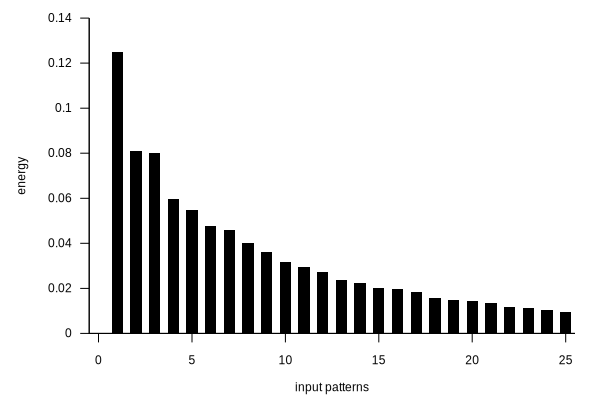

In [4]:
let () =
    let display_id = Jupyter_notebook.display "text/html" "" in
    let open Gp in
    let figure (module P: Plot) = P.plot (A q_evals) ~using:"($0+1):1" ~style:"boxes fs solid 1.0 noborder fc rgb 'black' lw 2"
        [ barebone ; 
          set "boxwidth 0.6";
          borders [`left;`bottom]; 
          tics "out nomirror"; 
          xrange (-0.5,25.5);
          xlabel "input patterns";
          ylabel "energy"] in
    Juplot.draw ~display_id figure

###  Plot the network's impulse response to the 1st, 50th, and 200th eigenvector of $Q$

val modes : int array = ...


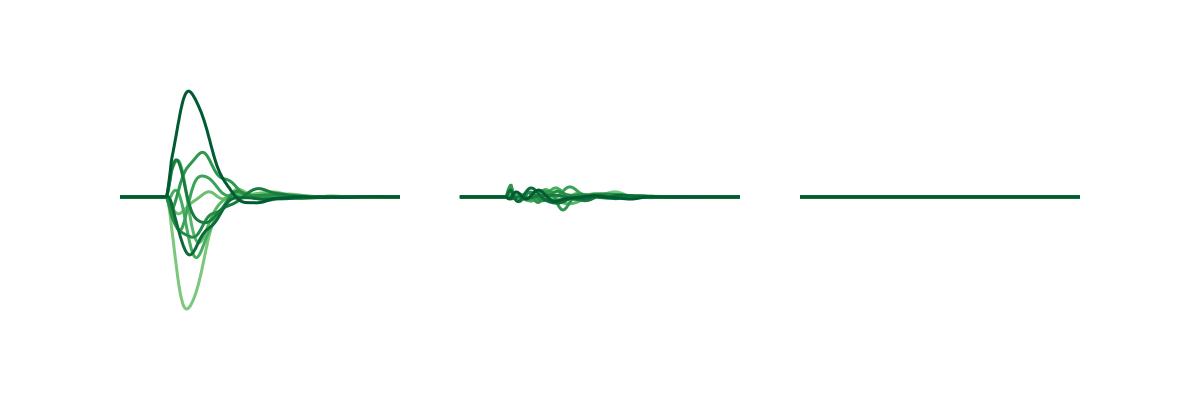

In [5]:
let modes = [|0; 49; 199|]
let () =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  let get mode =  
      let x0 = Mat.(row u mode) in
      let x = simulate ~c ~input:x0 0.3 in
      List.init 10 (fun i -> item (A x) ~using:(sprintf "1:%i" (i+2)) ~style:(sprintf "l lw 3 lc palette cb %i" (succ i))) in
  let figure (module P: Plot) = 
      P.ex "load 'greens.pal'";
      P.multiplot ~spacing:(0.05,0.0) (1,3) (fun k row col ->
      P.plots  
      (get modes.(k))
      [ barebone ; 
        yrange (-5.2,5.)] 
      ) in
  Juplot.draw ~display_id ~size:(1200,400) figure